In [1]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069363+0j) [] +
(-0.025810254414814746+0j) [X0 X1 Y2 Y3] +
(-0.012799934786437116+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839897802+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786437116+0j) [X0 X1 X3 X4] +
(-0.0251596458398978+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.017114528821774704+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103629107+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103629107+0j) [X0 X1 X5 X6] +
(-0.054698565746849545+0j) [X0 X1 Y6 Y7] +
(0.025810254414814746+0j) [X0 Y1 Y2 X3] +
(0.012799934786437116+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839897802+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786437116+0j) [X0 Y1 Y3 X4] +
(-0.0251596458398978+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.017114528821774704+0j) [X0 Y1 Y4 X5] +
(0.0009891049103629107+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103629107+0j) [X0 Y1 Y5 X6] +
(0.054698565746849545+0j) [X0 Y1 Y6 X7] +
(0.0025779051794112932+0j) [X0 Z1 X2] +
(0.004766148105680655+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923307723+0j) [X0 Z1 X2 X3 

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [3]:
ham = q_conv.QubitOperator_to_dict(ham_q, num_qubits)
anz_terms = list((q_conv.QubitOperator_to_dict(ucc_q, num_qubits)).keys())
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
#ham_noncon
terms_context = list(ham.keys() - terms_noncon)
ham_context = {t:ham[t] for t in terms_context}
#ham_context
c.contextualQ_ham(ham_context)

True

In [4]:
from qiskit.aqua.algorithms import NumPyEigensolver

result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham)).run()
true_gs = np.real(result.eigenvalues)

print(true_gs)

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


[-3.16676548]


/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


In [5]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}
c.csvqe_approximations_heuristic(ham, ham_noncon, num_qubits, true_gs)
#c.contextualQ_ham(ham_context)

[array([-3.16676548]),
 [-3.14282474926818,
  -3.151872881862983,
  -3.151872881862987,
  -3.1557103882871376,
  -3.1591148519137597,
  -3.1591148519137637,
  -3.1619490056505253,
  -3.1667654772544194,
  -3.1667654772544083],
 [array([0.02394073]),
  array([0.0148926]),
  array([0.0148926]),
  array([0.01105509]),
  array([0.00765063]),
  array([0.00765063]),
  array([0.00481647]),
  array([2.22044605e-15]),
  array([1.33226763e-14])],
 [6, 0, 2, 4, 3, 1, 5, 7]]

In [6]:
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
A

{'YZZZZZYZ': 0.04017218674809687, 'IIIIIIZI': 0.9991927718973331}

# The epistemic state defines a classical probability distribution:

In [7]:
def ontic_prob(ep_state, ontic_state):
    
    if ep_state[0] != ontic_state[0]:
        return 0
    
    else:
        prod = 1
        for index, r in enumerate(ep_state[1]):
            f = 1/2 * abs(r + ontic_state[1][index])
            prod *= f
        
        return prod    

def epistemic_dist(ep_state):
    size_G = len(ep_state[0])
    size_Ci = len(ep_state[1])
    size_R = size_G + size_Ci
    
    ep_prob = {}
    
    ontic_states = list(itertools.product([1, -1], repeat=size_R))
    
    for o in ontic_states:
        o_state = [list(o[0:size_G]), list(o[size_G:size_R])]
        o_prob = ontic_prob(ep_state, o_state)
        
        if o_prob != 0:
            ep_prob[o] = o_prob
    
    return ep_prob

In [8]:
epistemic_dist(ep_state)

{(-1, -1, 1, -1, 1, 1, 1, 1, 1): 0.5198761793188595,
 (-1, -1, 1, -1, 1, 1, 1, 1, -1): 0.00020991405518887838,
 (-1, -1, 1, -1, 1, 1, 1, -1, 1): 0.47972020662980697,
 (-1, -1, 1, -1, 1, 1, 1, -1, -1): 0.0001936999961445557}

# Find a simultaneous eigenstate of the operators G_i and A:

In [9]:
from copy import deepcopy

G = model[0]
fixed_qubits = ['I' for i in range(num_qubits)]
basis_ops = []
mult_Z_indices = []

for index, g in enumerate(G):
    Z_indices = [i for i, p in enumerate(list(g)) if p == 'Z']
    if len(Z_indices) == 1:
        if ep_state[0][index] == -1:
            fixed_qubits[Z_indices[0]] = 1
        else:
            fixed_qubits[Z_indices[0]] = 0
    else:
        mult_Z_indices.append([ep_state[0][index], Z_indices])
        
print(fixed_qubits)

for Z_indices in mult_Z_indices:
    Z0, Z1 = Z_indices[1][0], Z_indices[1][1] 
    q0, q1 = fixed_qubits[Z0], fixed_qubits[Z1]
    
    if q0 != q1:
        if q0 != 'I':
            if Z_indices[0] == -1:
                fixed_qubits[Z1] = (q0+1)%2
            else:
                fixed_qubits[Z1] = q0
        else:
            if Z_indices[0] == -1:
                fixed_qubits[Z0] = (q1+1)%2
            else:
                fixed_qubits[Z0] = q1
        mult_Z_indices.remove(Z_indices)
            
for Z_indices in mult_Z_indices:
    if Z_indices[0] == -1:
        fixed = deepcopy(fixed_qubits)
        fixed[Z_indices[1][0]] = 0
        fixed[Z_indices[1][1]] = 1
        fixed = [str(i) for i in fixed]
        basis_ops.append(''.join(fixed))
        
        fixed = deepcopy(fixed_qubits)
        fixed[Z_indices[1][0]] = 1
        fixed[Z_indices[1][1]] = 0
        fixed = [str(i) for i in fixed]
        basis_ops.append(''.join(fixed))
    
print(basis_ops)

['I', 'I', 0, 1, 0, 0, 'I', 0]
['01010010', '11010000']


# Construct +1-Eigenstates of A(r)

In [10]:
r1 = ep_state[1][0]
r2 = ep_state[1][1]
#t = np.arctan((r2 + 1) / r1)
parity=3
q1=1
amp_ratio = (1 + r2 * (-1)**q1) / (r1 * (-1)**(1 + parity))
t = np.arctan(amp_ratio)

r1, r2, np.sin(t), np.cos(t)

(0.04017218674809687,
 0.9991927718973331,
 0.0200901481162644,
 0.9997981726071851)

In [13]:
from openfermion.linalg import LinearQubitOperator

ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = q_conv.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = q_conv.dict_to_QubitOperator(ham_context, num_qubits)

#take expectation value algebraically

for p in np.linspace(0, 1, 1):
    psi = add_eigenstate(r1=r1, r2=r2, index=82, theta=0, n=0, num_qubits=num_qubits)
    expect = expectation(ham_q, psi)
    
    print('<H> w.r.t. simultaneous eigenstate:', expect)
    print('Noncontextual approximation:', gs_noncon_energy)
    print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-3.1428247492681787+0j)
Noncontextual approximation: -3.1428247492681796
Expectation values match? True


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


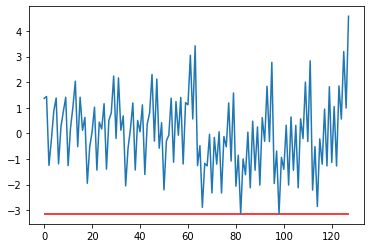

In [14]:
from matplotlib import pyplot as plt

X=[]
Y=[]

for i in range(2**(num_qubits-1)):
    X.append(i)
    psi = add_eigenstate(r1=r1, r2=r2, index=i, theta=0, n=0, num_qubits=num_qubits)

    Y.append(expectation(ham_noncon_q, psi))

plt.plot(X, Y)
plt.hlines(gs_noncon_energy, 0, 127, color='r')
plt.show()

In [15]:
import math

def random_vector(n):
    components = [np.random.normal() for i in range(n)]
    r = math.sqrt(sum(x*x for x in components))
    v = [x/r for x in components]
    return v

In [131]:
import itertools
from itertools import chain, combinations
from copy import deepcopy

def bin_to_int(bits):
    bit_string = deepcopy(bits)
    if type(bit_string) == str:
        bit_string = [int(b) for b in bit_string]
    for index, b in enumerate(bit_string):
        bit_string[index] = b * 2 ** (len(bit_string)-index-1)
    return sum(bit_string)


def int_to_bin(integer, num_qubits):
    if integer >= 2**num_qubits:
        raise ValueError('Input integer larger than specified number of bits')
    bin_str=bin(integer)[2:]
    leading_0 = ''.join(['0' for i in range(num_qubits-len(bin_str))])
    return leading_0 + bin_str


def add_eigenstate(r1, r2, index, theta, n, num_qubits, custom_amp=None):
    """
    """
    B = list(itertools.product([0,1], repeat=num_qubits))
    b1 = list(B[index])
    b2 = deepcopy(b1)
    b2[0] = (b2[0]+1)%2
    b2[6] = (b2[6]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)

    parity=sum(b1)
    q1 = b1[6]
    
    amp_ratio = (1 + r2 * (-1)**q1) / (r1 * (-1)**(1 + parity))
    t = ((-1)**n)*np.arctan(amp_ratio)
    psi = [0 for i in range(2**num_qubits)]

    if custom_amp is None:   
        psi[i1] = np.sin(t)*np.exp(1j*theta)
        psi[i2] = np.cos(t)*np.exp(1j*(theta - n*np.pi))
    else:
        psi[i1] = custom_amp[0]
        psi[i2] = custom_amp[1]
        
    return np.array(psi)


def expectation(op, state):
    state = np.array(state)
    conj_state = np.conjugate(state)
    O = LinearQubitOperator(op, num_qubits)
    
    O_state = O.matvec(state)
    expect = conj_state.dot(O_state)
    
    return expect


def discard_generator(ham_noncon, ham_context, generators):
    new_ham_noncon = deepcopy(ham_noncon)
    new_ham_context = deepcopy(ham_context)
    
    Z_indices = [g.index('Z') for g in generators]
    removed=[]
    
    for index in Z_indices:
        for p in ham_noncon:
            if p not in removed:
                if p[index] == 'Z':
                    new_ham_context[p] = ham_noncon[p]
                    del new_ham_noncon[p]
                    removed.append(p)
            
    return new_ham_noncon, new_ham_context


def rotate_operator(rotations, op):
    rot_op = {}
    
    for p in op.keys():
        p_ref = deepcopy(p)
        parity = 1
        coeff = op[p]
        for r in rotations:
            rotate_p = c.apply_rotation(r, p)
            p = list(rotate_p.keys())[0]
            parity *= rotate_p[p]
        
        rot_op[p] = parity * coeff
        
    return rot_op

def rotate_hamiltonian(rotations, ham, ham_noncon, ham_context):
    
    rot_ham={}
    rot_ham_noncon={}
    rot_ham_context={}

    for p in ham.keys():
        p_ref = deepcopy(p)
        parity = 1
        coeff = ham[p]
        for r in rotations:
            rotate_p = c.apply_rotation(r, p)
            p = list(rotate_p.keys())[0]
            parity *= rotate_p[p]
        
        rot_ham[p] = parity * coeff
        if p_ref in ham_noncon.keys():
            rot_ham_noncon[p] = parity * coeff
        else:
            rot_ham_context[p] = parity * coeff
            
    return rot_ham, rot_ham_noncon, rot_ham_context


def rotate_state(rotations, state):
    
    rot_state = deepcopy(state)
    
    for r in rotations:
        r_op = QubitOperator('', 1/np.sqrt(2)) - q_conv.dict_to_QubitOperator({r[1]: 1/np.sqrt(2)*1j}, num_qubits)
        r_op = LinearQubitOperator(r_op, num_qubits)
        rot_state = r_op.matvec(rot_state)
        
    return rot_state


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def find_eigenstate_indices(initial, removed_Z_indices):
    bins = []
    index_powerset = list(powerset(removed_Z_indices))
    
    for comb in index_powerset:
        initial_ref = list(deepcopy(initial))
        for c in comb:
            initial_ref[c] = str((int(initial_ref[c])+1)%2)
        bins.append(bin_to_int(''.join(initial_ref)))
    
    return bins


def expectation_optimiser(ham_n, ham_c, amps, initial_state, Z_indices, num_qubits, rotations=None):
    eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
    
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(eigenstate_indices):
        psi += (amps[index])*add_eigenstate(r1=r1, r2=r2, theta=0, n=0, index=i, num_qubits=num_qubits)
    
    if rotations is not None:
        psi = rotate_state(rotations, psi)
    
    expect_noncon = expectation(ham_n, psi)
    expect_context = expectation(ham_c, psi)
    
    return expect_noncon, expect_context

In [17]:
generators = model[0]
#rot_G=[]
#rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]

#for g in G:
#    for r in rotations:
#        rotate_g = c.apply_rotation(r, g)
#        g = list(rotate_g.keys())[0]
#    rot_G.append(g)
    
#print(G, rot_G)
generators

['ZIIIIIZI',
 'IZIIIIIZ',
 'IIZIIIII',
 'IIIZIIII',
 'IIIIZIII',
 'IIIIIZII',
 'IIIIIIIZ']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII'] [7, 5, 4, 3, 2]


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII'] [7, 5, 4, 3]
['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII'] [7, 5, 4]
['IIIIIIIZ', 'IIIIIZII'] [7, 5]
['IIIIIIIZ'] [7]
[] []


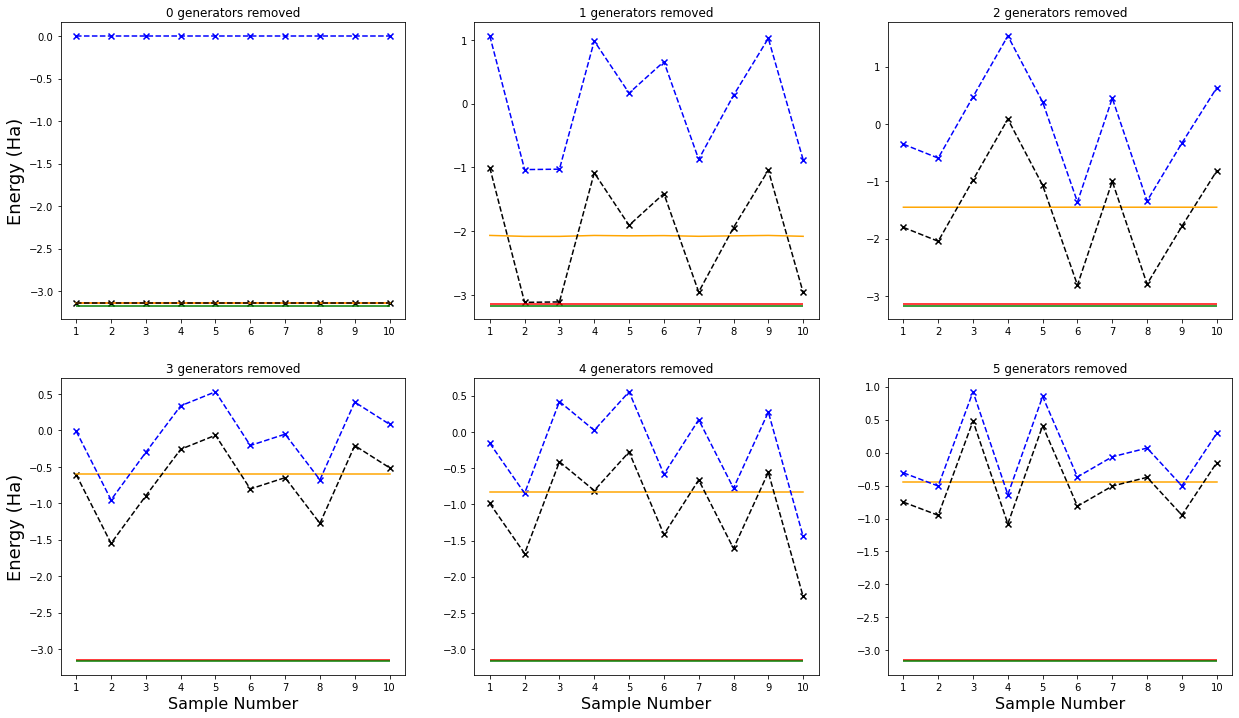

In [74]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10
initial_state = '01010010'

#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
grid_pos.reverse()

X=list(range(1, shots+1))
print(X)
for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(index+2, 7))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = discard_generator(ham_noncon, ham_context, removed_generators)

    #rot_ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
    new_ham_noncon_q = q_conv.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = q_conv.dict_to_QubitOperator(new_ham_context, num_qubits)

    eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
    amps=[random_vector(len(eigenstate_indices)) for i in range(shots)]
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for p in amps:
        expect_noncon, expect_context = expectation_optimiser(ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
                                                              amps=p, initial_state=initial_state, Z_indices=Z_indices, num_qubits=num_qubits)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index-5))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

# Do we have any quantum corrections?

In [19]:
G = model[0]
terms_context = list(ham_context.keys())
G

['ZIIIIIZI',
 'IZIIIIIZ',
 'IIZIIIII',
 'IIIZIIII',
 'IIIIZIII',
 'IIIIIZII',
 'IIIIIIIZ']

In [63]:
new_ham_noncon, new_ham_context = discard_generator(ham_noncon, ham_context, ['ZIIIIIZI'])

q_corr_terms = []

for t in list(new_ham_context.keys()):
    commutes = []
    for g in G:
        if c.commute(t, g):
            commutes.append(g)
    #print(t, 'commutes with the noncontextual generators:', commutes)
    if commutes == G:
        q_corr_terms.append(t)
        
if q_corr_terms == []:
    print('No quantum correction')
else:
    print('Terms admitting quantum correction:', q_corr_terms)

Terms admitting quantum correction: ['ZZIIIIII', 'ZIIIIIIZ', 'ZIIIIIZI', 'ZIIIIZII', 'ZIIIIIII', 'ZIIZIIII', 'ZIIIZIII', 'ZIZIIIII']


In [21]:
ucc = q_conv.QubitOperator_to_dict(ucc_q, num_qubits)
anz_terms = list(ucc.keys())
print(anz_terms)

['YZXIIIII', 'XZYIIIII', 'YYYXIIII', 'YXYYIIII', 'XXYXIIII', 'XYYYIIII', 'YXXXIIII', 'YYXYIIII', 'XYXXIIII', 'XXXYIIII', 'IYZXIIII', 'IXZYIIII', 'YZZZXIII', 'XZZZYIII', 'YYIIYXII', 'YXIIYYII', 'XXIIYXII', 'XYIIYYII', 'YXIIXXII', 'YYIIXYII', 'XYIIXXII', 'XXIIXYII', 'IYZZZXII', 'IXZZZYII', 'YZZZZZXI', 'XZZZZZYI', 'YYIIIIYX', 'YXIIIIYY', 'XXIIIIYX', 'XYIIIIYY', 'YXIIIIXX', 'YYIIIIXY', 'XYIIIIXX', 'XXIIIIXY', 'IYZZZZZX', 'IXZZZZZY']


In [22]:
import cs_vqe_ansatz as c_anz

anz = c_anz.construct_ansatz(init_state = [1, 3, 6], paulis = anz_terms)
anz.draw()
#from qiskit import QuantumCircuit
#from qiskit.extensions import Initialize
#from qiskit.circuit import Parameter

#anz = QuantumCircuit(num_qubits) # We are redefining qc
#anz.initialize(psi)
#anz.ry(Parameter('x'), 3)
#anz.initialize(psi2)
#anz.rx(Parameter('y'), 3)

░ ┌─────┐┌───┐                                 ┌───┐┌───┐ ░  ░ »
q_0: ──────░─┤ SDG ├┤ H ├──■───────────────────────────■──┤ H ├┤ S ├─░──░─»
     ┌───┐ ░ └─────┘└───┘┌─┴─┐                       ┌─┴─┐└───┘└───┘ ░  ░ »
q_1: ┤ X ├─░─────────────┤ X ├──■─────────────────■──┤ X ├───────────░──░─»
     └───┘ ░  ┌───┐      └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤           ░  ░ »
q_2: ──────░──┤ H ├───────────┤ X ├┤ RZ(2*αβγ) ├┤ X ├┤ H ├───────────░──░─»
     ┌───┐ ░  └───┘           └───┘└───────────┘└───┘└───┘           ░  ░ »
q_3: ┤ X ├─░─────────────────────────────────────────────────────────░──░─»
     └───┘ ░                                                         ░  ░ »
q_4: ──────░─────────────────────────────────────────────────────────░──░─»
           ░                                                         ░  ░ »
q_5: ──────░─────────────────────────────────────────────────────────░──░─»
     ┌───┐ ░                                                         ░  ░ »
q_6: ┤ X ├─░─────────────────────────────────────────────────────────░──░─»
     └───┘ ░                                                         ░  ░ »
q_7: ──────░─────────────────────────────────────────────────────────░──░─»
           ░                                                         ░  ░ »
«      ┌───┐                                  ┌───┐ ░  ░ ┌─────┐┌───┐          »
«q_0: ─┤ H ├───■───────────────────────────■──┤ H ├─░──░─┤ SDG ├┤ H ├──■───────»
«      └───┘ ┌─┴─┐                       ┌─┴─┐└───┘ ░  ░ ├─────┤├───┤┌─┴─┐     »
«q_1: ───────┤ X ├──■─────────────────■──┤ X ├──────░──░─┤ SDG ├┤ H ├┤ X ├──■──»
«     ┌─────┐├───┤┌─┴─┐┌───────────┐┌─┴─┐├───┤┌───┐ ░  ░ ├─────┤├───┤└───┘┌─┴─┐»
«q_2: ┤ SDG ├┤ H ├┤ X ├┤ RZ(2*αβδ) ├┤ X ├┤ H ├┤ S ├─░──░─┤ SDG ├┤ H ├─────┤ X ├»
«     └─────┘└───┘└───┘└───────────┘└───┘└───┘└───┘ ░  ░ └┬───┬┘└───┘     └───┘»
«q_3: ──────────────────────────────────────────────░──░──┤ H ├────────────────»
«                                                   ░  ░  └───┘                »
«q_4: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«q_5: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«q_6: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«q_7: ──────────────────────────────────────────────░──░───────────────────────»
«                                                   ░  ░                       »
«                                      ┌───┐┌───┐ ░  ░ ┌─────┐┌───┐          »
«q_0: ──────────────────────────────■──┤ H ├┤ S ├─░──░─┤ SDG ├┤ H ├──■───────»
«                                 ┌─┴─┐├───┤├───┤ ░  ░ └┬───┬┘└───┘┌─┴─┐     »
«q_1: ─────────────────────────■──┤ X ├┤ H ├┤ S ├─░──░──┤ H ├──────┤ X ├──■──»
«                            ┌─┴─┐├───┤├───┤└───┘ ░  ░ ┌┴───┴┐┌───┐└───┘┌─┴─┐»
«q_2: ──■─────────────────■──┤ X ├┤ H ├┤ S ├──────░──░─┤ SDG ├┤ H ├─────┤ X ├»
«     ┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘└───┘      ░  ░ ├─────┤├───┤     └───┘»
«q_3: ┤ X ├┤ RZ(2*αβε) ├┤ X ├┤ H ├────────────────░──░─┤ SDG ├┤ H ├──────────»
«     └───┘└───────────┘└───┘└───┘                ░  ░ └─────┘└───┘          »
«q_4: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                       »
«q_5: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                       »
«q_6: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                       »
«q_7: ────────────────────────────────────────────░──░───────────────────────»
«                                                 ░  ░                       »

In [23]:
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.opflow.primitive_ops import PauliOp
from qiskit import Aer

ham_qiskit = q_conv.dict_to_WeightedPauliOperator(ham)

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
slsqp = SLSQP(maxiter=10000)

vqe = VQE(anz, optimizer=slsqp, quantum_instance=qi)
vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham_qiskit)
vqe_result = vqe_run.optimal_value# + shift

print('VQE:', vqe_result, '|', 'Noncontextual Ground State:', gs_noncon_energy, 'True Ground State:', true_gs)

VQE: -3.1622625207620474 | Noncontextual Ground State: -3.1428247492681796 True Ground State: [-3.16676548]


NameError: name 'converge_cnts' is not defined

In [60]:
from qiskit.aqua.algorithms import NumPyEigensolver

order = [6, 2,3,0,1,4,5,7]
print(c.contextual_subspace_approximations(ham,model,fn_form,ep_state,order))

result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham)).run()
exact_energy = np.real(result.eigenvalues)

print(exact_energy)

[-3.14282474926818, -3.1518728818629844, -3.151872881862986, -3.151872881862988, -3.1557103882871247, -3.158335476766274, -3.161949005650526, -3.166765477254423, -3.166765477254399]
[-3.16676548]


In [64]:
rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]
#rotations.reverse()
rotations

[['pi/2', 'YIIIIIII'],
 ['pi/2', 'YIIIIIZI'],
 ['pi/2', 'IYIIIIII'],
 ['pi/2', 'IYIIIIIZ']]

In [65]:
rot_G=[]

for g in G:
    for r in rotations:
        rotate_g = c.apply_rotation(r, g)
        g = list(rotate_g.keys())[0]
    rot_G.append(g)
    
rot_G

['ZIIIIIII',
 'IZIIIIII',
 'IIZIIIII',
 'IIIZIIII',
 'IIIIZIII',
 'IIIIIZII',
 'IIIIIIIZ']

In [71]:
from openfermion.linalg import LinearQubitOperator

psi = add_eigenstate(r1=r1, r2=r2, theta=0, n=0, index=82, num_qubits=num_qubits)
rot_psi = rotate_state(rotations, psi)
rot_psi_conj = np.conjugate(rot_psi)

#rot_ham = c.get_reduced_hamiltonians(ham,model,fn_form,ep_state,order=[0,1,2,3,4,5,6,7])[8]

rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
rot_ham_noncon_q = q_conv.dict_to_QubitOperator(rot_ham, num_qubits)

#take expectation value algebraically
rot_H = LinearQubitOperator(rot_ham_noncon_q, num_qubits)
rot_H_psi = rot_H.matvec(rot_psi)
rot_expect = rot_psi_conj.dot(rot_H_psi)

print('<H> w.r.t. rotated simultaneous eigenstate:', rot_expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(rot_expect - gs_noncon_energy) < 10**-14) #sanity check - expectation values match? 

<H> w.r.t. rotated simultaneous eigenstate: (-3.142824749268177+0j)
Noncontextual approximation: -3.1428247492681796
Expectation values match? True


['IIZIIIII', 'IIIZIIII', 'ZIIIIIII'] [2, 3, 0]
[82, 114, 66, 210, 98, 242, 194, 226]
(-3.142324662228115+0j) False [0.999499874937461, -0.013041057576694923, -0.016221874241779375, -0.002536397192851207, 0.0005815461231430425, 0.009078617638310244, -0.021325891461334793, 0.004774427914285369]
(-3.1406315194624312+0j) False [0.999499874937461, 0.002819137127571888, -0.01862478256607172, 0.007978493390738218, -0.0037382114336245937, -0.02325490813137359, 0.00012527804724566839, 0.005170387986042756]
(-3.1431154985722647+0j) True [0.999499874937461, -0.012921693167164058, -0.019176828147689864, 0.0025891939190114243, 0.017941851982617454, 0.009075770198954721, -0.0018744461989001736, 0.007126147410377541]
(-3.141998600315188+0j) False [0.999499874937461, 0.005551653042600609, 0.007391018040605268, 0.01167846969603062, 0.018441665830071122, 0.0009937859168729015, 0.016880761815788375, 0.01233379819272877]
(-3.14231178187155+0j) False [0.999499874937461, -0.005985057145214793, -0.0035948672

/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


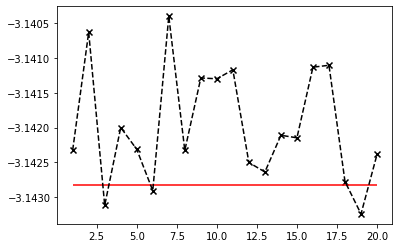

In [273]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=20
initial_state = '01010010'

removed_index = [2,3,0]
removed_generators = [rot_G[i] for i in removed_index]
Z_indices = [g.find('Z') for g in removed_generators]
print(removed_generators, Z_indices)

rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
new_rot_ham_noncon, new_rot_ham_context = discard_generator(rot_ham_noncon, rot_ham_context, removed_generators)
new_rot_ham_noncon_q = q_conv.dict_to_QubitOperator(new_rot_ham_noncon, num_qubits)
new_rot_ham_context_q = q_conv.dict_to_QubitOperator(new_rot_ham_context, num_qubits)

eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
print(eigenstate_indices)

prob=0.999
amps=[]
for i in range(shots):
    amp_1 = [np.sqrt(prob)]
    amp_rest = [np.sqrt(1-prob)*a for a in random_vector(len(eigenstate_indices)-1)]
    amp_1 += amp_rest
    amps.append(amp_1)

X=list(range(1, shots+1))
Y_noncon=[]
Y_context=[]
Y_combined=[]
Y_full=[]

#A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
#A = LinearQubitOperator(A_op, num_qubits)

for p in amps:
    expect_noncon, expect_context = expectation_optimiser(ham_n=new_rot_ham_noncon_q, ham_c=new_rot_ham_context_q, amps=p,
                                                          initial_state=initial_state,num_qubits=num_qubits,Z_indices=Z_indices,rotations=rotations)
    total = expect_noncon + expect_context
    #Y_full.append(expect_full)
    Y_noncon.append(expect_noncon)
    Y_context.append(expect_context)
    Y_combined.append(total)
    print(total, total < gs_noncon_energy, p)

#plt.plot(X, Y_noncon, color='orange')
#plt.scatter(X, Y_context, color='blue', marker = 'x')
#plt.plot(X, Y_context, color='blue', ls='--')
plt.scatter(X, Y_combined, color='black', marker = 'x')
plt.plot(X, Y_combined, color='black', ls='--')
plt.hlines(gs_noncon_energy, 1, shots, color='r')
#plt.hlines(true_gs, 1, shots, color='g')

In [96]:
gs_noncon_energy

-3.1428247492681796

In [305]:
(-3.14173689169366+0j) False [-0.6561365569846744, -0.006775889146723866, 0.029173298604223765, -0.7540476275164038], [82, 114, 66, 98]

SyntaxError: invalid syntax (<ipython-input-305-efac774a190c>, line 1)

True [0.8023829741984966, -0.05925243682903874, -0.5938608519225658] (-3.143600473788456+0j) -3.1428247492681796
False [-0.4146772931504254, 0.8353594522063181, -0.36085638161877676] (-2.0053534863265803+0j) -3.1428247492681796
False [0.4937478040197192, -0.2676270526097526, 0.8273988558954634] (-3.0398869838287896+0j) -3.1428247492681796
False [0.057794342242851474, 0.010526878763264714, 0.9982730081637085] (-3.141041769611586+0j) -3.1428247492681796
False [0.9571036800815338, 0.27631911722585656, -0.08717964802583449] (-2.971977324405283+0j) -3.1428247492681796
False [0.045755327613187416, 0.012451731476640393, -0.9988750694547559] (-3.1409704383901116+0j) -3.1428247492681796
False [-0.7538352566456722, 0.5016960515123507, 0.42430352076652633] (-2.7712135159206586+0j) -3.1428247492681796
False [0.7028453395904112, 0.6707599680560683, 0.23683220614912567] (-2.3028668580786524+0j) -3.1428247492681796
False [-0.09308213236089442, -0.5898756049602879, -0.802111268657836] (-2.539849399373

False [0.09671682087800033, -0.008868462373131745, -0.9952724285010558] (-3.1413306408338237+0j) -3.1428247492681796
False [0.8650535078195181, -0.1594263227475614, 0.47567391795676295] (-3.1202891880414776+0j) -3.1428247492681796
False [0.16318950714412717, 0.9028072239323188, 0.3978797571800768] (-1.729548218281576+0j) -3.1428247492681796
False [0.6204298939064314, 0.6174512247606836, -0.48355013368707256] (-2.4333088303433446+0j) -3.1428247492681796
False [-0.32344133807687325, -0.14986577190214417, -0.9343050632610401] (-3.095757116827432+0j) -3.1428247492681796
False [0.8558238409386254, -0.3909004463940256, -0.33876598750466386] (-2.9333209061791834+0j) -3.1428247492681796
True [0.671238485231734, -0.04005338397184556, -0.7401585116555853] (-3.143388918037456+0j) -3.1428247492681796
False [-0.9501641551529728, -0.2414971969689303, 0.19714761504666306] (-3.0080620499221724+0j) -3.1428247492681796
False [-0.09588606984142971, -0.8326374489577617, -0.5454546179137868] (-1.9474354621

/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


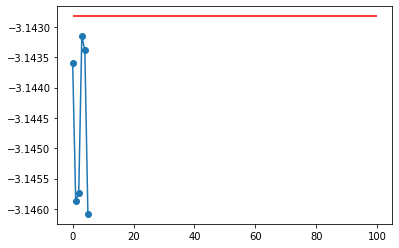

In [57]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=100

H = LinearQubitOperator(ham_q, num_qubits)
indices = [82, 88, 98]
X=[random_vector(len(indices)) for i in range(shots)]
Y=[]
success=[]
#A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
#A = LinearQubitOperator(A_op, num_qubits)

for amps in X:
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(indices):
        psi += (amps[index])*add_eigenstate(r1=r1, r2=r2, theta=0, n=0, index=i, num_qubits=num_qubits)
    psi_conj = np.conjugate(psi)

    H_psi = H.matvec(psi)
    expect = psi_conj.dot(H_psi)
    print(expect<gs_noncon_energy, amps, expect, gs_noncon_energy)
    if expect<gs_noncon_energy:
        Y.append(expect)
        success.append(amps)
    #Verify +1-eigenstate
    #A_psi = A.matvec(psi)
    #print(psi_conj.dot(A_psi))

plt.plot(range(len(Y)), Y)
plt.scatter(range(len(Y)), Y)
plt.hlines(gs_noncon_energy, 0, shots, color='r')
#print('<H> w.r.t. simultaneous eigenstate:', expect)
#print('Noncontextual approximation:', gs_noncon_energy)
#print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [58]:
success_temp = success

In [59]:
success_temp, [82, 88, 98]

([[0.8023829741984966, -0.05925243682903874, -0.5938608519225658],
  [-0.9982006904765267, 0.029715361137994653, 0.05208050349817877],
  [-0.997262946679045, 0.062324494603780554, -0.03977778969992641],
  [-0.8931208889623151, 0.07550558128113702, 0.4434343073044322],
  [0.671238485231734, -0.04005338397184556, -0.7401585116555853],
  [-0.9981022641125852, 0.05513614013828153, 0.027420365132192218]],
 [82, 88, 98])

In [40]:
optimizers = [COBYLA(maxiter=80),SLSQP(maxiter=60)]
len(optimizers)

2

In [ ]:
def bin_to_int(bits):
    if type(bits) == str:
        bits = [int(b) for b in bits]
    for index, b in enumerate(bits):
        bits[index] = b * 2 ** (len(bits)-index-1)
    return sum(bits)

In [ ]:
from copy import deepcopy

v1 = [0,0,0,0,1,1,1,1]
v2 = deepcopy(v1)
v2[0] = (v2[0]+1)%2
v2[6] = (v2[6]+1)%2

In [ ]:
bin_to_int(v1), bin_to_int(v2)

In [ ]:
import itertools
from matplotlib import pyplot as plt

B = list(itertools.product([0,1], repeat=8))

X=[]
Y=[]

for b1 in B[0:128]:
    b1 = list(b1)
    b2 = deepcopy(b1)
    b2[0] = (b2[0]+1)%2
    b2[6] = (b2[6]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    X.append(i1)
    Y.append(i2)
    print(i1, i2, i2-i1)
    
plt.scatter(X, Y, s=3)

In [ ]:
np.exp(0.6*1j)

In [44]:
bin_to_int('01011010')

90

In [94]:
from openfermion.linalg import get_sparse_operator, get_ground_state, generate_linear_qubit_operator

sparse_ham_q = get_ground_state(get_sparse_operator(ham_noncon_q, num_qubits).toarray())
sparse_ham_q

(-3.142824749268173,
 array([-1.19117873e-17-7.11284889e-18j, -5.66646440e-19-5.70657101e-18j,
        -1.53298051e-17+1.62052392e-17j,  5.09279128e-19-3.10038739e-17j,
         3.68429430e-19-6.31403293e-18j,  3.77770764e-19+1.21064692e-17j,
         6.33554997e-18-7.15644797e-18j,  2.87665258e-17+2.14869193e-17j,
         3.41862253e-18-8.52926357e-18j,  2.34593376e-17+1.54060510e-17j,
        -2.14590652e-17+8.74999066e-18j, -1.26456699e-17+1.01254335e-17j,
        -2.31381603e-18-5.07606463e-18j,  2.04492469e-20-4.80901755e-18j,
        -3.84888391e-18-2.39103023e-18j,  1.79836719e-18+7.20247430e-19j,
        -1.52501595e-18+4.95248746e-18j,  7.24244489e-19+8.46602085e-18j,
         1.99385777e-17+1.82911318e-17j,  1.31624890e-18+7.48784898e-19j,
        -1.44841044e-18-1.32783905e-17j,  1.33139035e-19-8.67574796e-19j,
        -3.78744096e-18-2.21173615e-19j,  9.67562679e-18-2.40163238e-17j,
         1.94475335e-17-1.59300388e-17j,  5.02653901e-18+2.03103002e-17j,
         7.719295

In [113]:
add_eigenstate(r1=r1, r2=r2, index=19, theta=0, n=0, num_qubits=num_qubits)[145]

(0.9997981730624983+0j)

In [179]:
discard_generator(ham_noncon, ham_context, ['IIIIIIIZ', 'IIIIIZII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII'])[0]

{'IIIIIIZI': (-1.140216532490733+0j),
 'IIIIIIII': (1.1324434021069387+0j),
 'ZIIIIIZI': (0.17642194958972313+0j),
 'ZIIIIIII': (0.1399063176082593+0j)}

In [62]:
eigenstate_indices = [82, 83, 86, 87, 90, 91, 94, 95]

In [72]:
initial = 82
indices = []
removed_Z_indices = [7, 5, 4]
for i in removed_Z_indices:
    indices.append(initial)
    indices.append(initial+1)
    
    initial += 2**i

indices





[82, 83, 86, 87, 94, 95]

In [288]:
print(sorted(find_eigenstate_indices('01010010', [2, 3])))

[66, 82, 98, 114]


In [264]:
from openfermion.linalg import get_sparse_operator, get_ground_state

gs = get_ground_state(get_sparse_operator(ham_q, num_qubits).toarray())
print(gs[0])

-3.166765477254412


In [265]:
amp_list = [abs(a)**2 for a in list(gs[1])]
sig_amp_list = [(str(index), a) for index, a in enumerate(amp_list) if a > 0.00001]
XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]

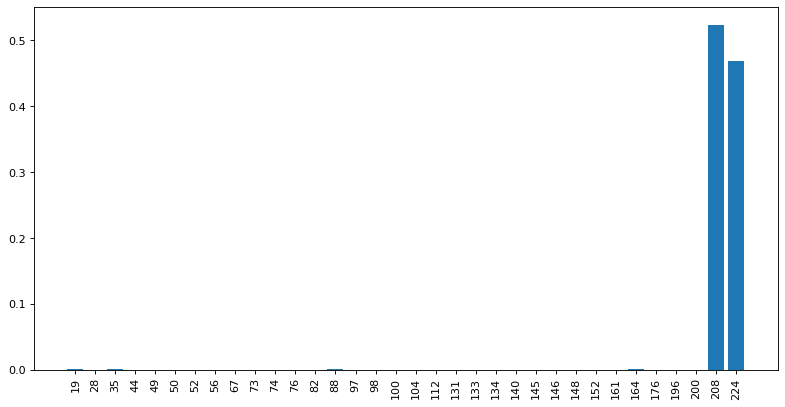

In [266]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

plt.bar(X, Y)
plt.xticks(rotation=90)
plt.show()

In [200]:
gs

array([ 7.27138694e-18-8.70123896e-18j,  8.84910352e-18+1.39698182e-17j,
        1.08530412e-17-6.70584621e-18j,  1.59967390e-17-1.66163873e-17j,
        1.10483604e-17+1.74760451e-18j, -9.23533658e-18-5.26331264e-18j,
        9.00643556e-19+1.19793825e-17j,  8.71622049e-06+1.58855839e-04j,
        1.19917000e-17-6.29171844e-19j,  9.64036011e-18+7.29361122e-18j,
       -7.01789464e-18-7.81662009e-18j,  1.79104165e-05+1.07607709e-04j,
        2.24473769e-17+9.69239210e-18j,  6.82568600e-05+1.24400258e-03j,
        1.40256754e-04+8.42677666e-04j, -1.76669262e-17-1.78356391e-18j,
       -6.83587966e-18-5.02218664e-18j, -2.83525606e-17+2.41858391e-17j,
       -5.83741152e-18+5.32049038e-18j,  1.90130827e-03+3.46519366e-02j,
        7.74633504e-18-3.36951428e-18j, -1.70040727e-18+9.34453174e-19j,
        3.67209690e-05+6.69251120e-04j, -1.73804214e-17+1.90172397e-18j,
       -1.48217637e-17+3.88614258e-18j, -7.53978372e-05-1.37414912e-03j,
       -7.94746784e-05-4.77492417e-04j, -1.65463799

In [77]:
bin_to_int('01010010')

88

In [98]:
B = list(itertools.product([0,1], repeat=num_qubits))
for index in range(128):
    b1 = list(B[index])
    b2 = deepcopy(b1)
    b2[0] = (b2[0]+1)%2
    b2[6] = (b2[6]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    print(i1, i2)

0 130
1 131
2 128
3 129
4 134
5 135
6 132
7 133
8 138
9 139
10 136
11 137
12 142
13 143
14 140
15 141
16 146
17 147
18 144
19 145
20 150
21 151
22 148
23 149
24 154
25 155
26 152
27 153
28 158
29 159
30 156
31 157
32 162
33 163
34 160
35 161
36 166
37 167
38 164
39 165
40 170
41 171
42 168
43 169
44 174
45 175
46 172
47 173
48 178
49 179
50 176
51 177
52 182
53 183
54 180
55 181
56 186
57 187
58 184
59 185
60 190
61 191
62 188
63 189
64 194
65 195
66 192
67 193
68 198
69 199
70 196
71 197
72 202
73 203
74 200
75 201
76 206
77 207
78 204
79 205
80 210
81 211
82 208
83 209
84 214
85 215
86 212
87 213
88 218
89 219
90 216
91 217
92 222
93 223
94 220
95 221
96 226
97 227
98 224
99 225
100 230
101 231
102 228
103 229
104 234
105 235
106 232
107 233
108 238
109 239
110 236
111 237
112 242
113 243
114 240
115 241
116 246
117 247
118 244
119 245
120 250
121 251
122 248
123 249
124 254
125 255
126 252
127 253


In [259]:
eigenstate_indices = find_eigenstate_indices('01010010', [2, 3])
eigenstates = [int_to_bin(i, num_qubits) for i in eigenstate_indices]
eigenstate_strings = []
for s in eigenstates:
    eigenstate_strings.append(s)
    b1 = list(s)
    b2 = deepcopy(b1)
    b2[0] = str((int(b2[0])+1)%2)
    b2[6] = str((int(b2[6])+1)%2)
    eigenstate_strings.append(''.join(b2))

eigenstate_strings

['01010010',
 '11010000',
 '01110010',
 '11110000',
 '01000010',
 '11000000',
 '01100010',
 '11100000']

In [174]:
eigenstate_strings_indices = []
for s in eigenstate_strings:
    X_index = ['I' for i in range(num_qubits)]
    for index, bit in enumerate(list(s)):
        if bit == '1':
            X_index[index] = 'X'
    eigenstate_strings_indices.append(''.join(X_index))
eigenstate_strings_indices

['IXIXIIXI',
 'XXIXIIII',
 'IXXXIIXI',
 'XXXXIIII',
 'IXIIIIXI',
 'XXIIIIII',
 'IXXIIIXI',
 'XXXIIIII']

In [272]:
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
%matplotlib inline
param_chars = ['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','ς','σ','τ','υ','φ','χ','ψ','ω']

indices = find_eigenstate_indices('01010010', [2, 3, 0])
print(indices)
psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
for index, i in enumerate(indices):
    psi += (np.sqrt(1/len(indices)))*add_eigenstate(r1=r1, r2=r2, theta=0, n=0, index=i, num_qubits=num_qubits)

anz = QuantumCircuit(8)
anz.initialize(psi)
for q in range(8):
    anz.ry(Parameter(param_chars[q]), q)
#anz.measure_all()

anz.draw()
#backend = BasicAer.get_backend('qasm_simulator')
#job = execute(anz, backend)
#plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

[82, 114, 66, 210, 98, 242, 194, 226]


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ├»
«     │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  │»
«q_1: ┤1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ├»
«     │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  │»
«q_2: ┤2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [270]:
bin_to_int('11110000')

240

In [271]:
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.opflow.primitive_ops import PauliOp
from qiskit import Aer

ham_qiskit = q_conv.dict_to_WeightedPauliOperator(ham)

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
slsqp = SLSQP(maxiter=5000)

vqe = VQE(anz, optimizer=slsqp, quantum_instance=qi)
vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham_qiskit)
vqe_result = vqe_run.optimal_value# + shift

print('VQE:', vqe_result, '|', 'Noncontextual Ground State:', gs_noncon_energy, 'True Ground State:', true_gs)

VQE: -3.1407501308429686 | Noncontextual Ground State: -3.1428247492681796 True Ground State: [-3.16676548]


TypeError: can't multiply sequence by non-int of type 'Parameter'

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(αβγ), Parameter(αβδ), Parameter(αβε), Parameter(αβζ), Parameter(αβη), Parameter(αβθ), Parameter(αβι), Parameter(αβκ)])]'

In [216]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)

qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [231]:
bin_to_int('11010000')

208